Importing relevant libraries and getting the CSV file from the S3 bucket. get_execution_role() is used to get the Identity & Access Management (IAM) role associated with where we are working from. The other lines in the cell point to where our dataset is so we can retrieve it from S3.

In [1]:
import matplotlib
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from urllib import request

data_location = '~/Desktop/fraudData.csv'

train_data = request.urlretrieve()
test_data = request.urlretrieve()

Reading the CSV file. For convenience, the pandas library is configured to show all columns when previewing the CSV file.

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(data_location)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


When evaluating the dataset, about 0.52% of transactions are fraudulent. This is usually the case when looking at transaction datasets - common sense tells us that people don't commit fraud that often! This makes it difficult to use ML to accurately detect fraud without accounting for this in some way.

In [3]:
count_not_fraud = df['is_fraud'].value_counts()[0]
count_fraud = df['is_fraud'].value_counts()[1]
print(str(count_fraud) + " transactions are fraudulent.")
print(str(count_not_fraud) + " transactions are legitimate.")
print("The rate of fraud in the dataset is approximately " + str(round((count_fraud/count_not_fraud * 100), 3)) + "%.")

9651 transactions are fraudulent.
1842743 transactions are legitimate.
The rate of fraud in the dataset is approximately 0.524%.


The count of unique values in the dataset is unremarkable. Almost all transactions have a unique time they took place, merchant location and price. The purchases seem to have been made by about 1000 people over a 2 year period. Other categories (e.g., gender, state, category, is_fraud) are self-explanatory. There aren't any null values in the dataset.

In [4]:
for i in df.columns:
    unique_value = df[i].nunique()
    print(f'Count of unique values in {i} =', unique_value)
    
df.isnull().sum()

Count of unique values in Unnamed: 0 = 1296675
Count of unique values in trans_date_trans_time = 1819551
Count of unique values in cc_num = 999
Count of unique values in merchant = 693
Count of unique values in category = 14
Count of unique values in amt = 60616
Count of unique values in first = 355
Count of unique values in last = 486
Count of unique values in gender = 2
Count of unique values in street = 999
Count of unique values in city = 906
Count of unique values in state = 51
Count of unique values in zip = 985
Count of unique values in lat = 983
Count of unique values in long = 983
Count of unique values in city_pop = 891
Count of unique values in job = 497
Count of unique values in dob = 984
Count of unique values in trans_num = 1852394
Count of unique values in unix_time = 1819583
Count of unique values in merch_lat = 1754157
Count of unique values in merch_long = 1809753
Count of unique values in is_fraud = 2


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

The cell below drops all columns except the transaction's price, latitude/longitude for both the merchant and customer (where the purchase was made and where the customer lives), and whether the transaction was fraudulent or not. Every merchant name starts with "fraud_" so that is removed to improve visibility. This was done to remove personal information from the dataset along with any other irrelevant information (e.g., gender, date of birth). A preview of the transformed dataset is shown below. 

In [5]:
df.drop(['Unnamed: 0', 'cc_num', 'first', 'last', 'gender', 
         'street', 'city', 'state', 'zip', 'city_pop', 'job', 'dob', 
         'unix_time', 'trans_date_trans_time'], axis=1, inplace=True)
df['merchant'] = df['merchant'].str.replace('fraud_','')
df.head()

,merchant,category,amt,lat,long,trans_num,merch_lat,merch_long,is_fraud
0,"Rippin, Kub and Mann",misc_net,4.97,36.0788,-81.1781,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,48.8878,-118.2105,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0
2,Lind-Buckridge,entertainment,220.11,42.1808,-112.2620,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0
3,"Kutch, Hermiston and Farrell",gas_transport,45.00,46.2306,-112.1138,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0
4,Keeling-Crist,misc_pos,41.96,38.4207,-79.4629,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0


In [16]:
df['category'] = df['category'].astype('category')
df['category'] = df['category'].cat.codes
df.head()

,merchant,category,amt,lat,long,trans_num,merch_lat,merch_long,is_fraud
0,"Rippin, Kub and Mann",8,4.97,36.0788,-81.1781,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0
1,"Heller, Gutmann and Zieme",4,107.23,48.8878,-118.2105,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0
2,Lind-Buckridge,0,220.11,42.1808,-112.2620,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0
3,"Kutch, Hermiston and Farrell",2,45.00,46.2306,-112.1138,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0
4,Keeling-Crist,9,41.96,38.4207,-79.4629,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0


In the dataset, fraud tends to be committed on higher value items, as shown in the box plot below. This is plausible - if one commits fraud, they may as well get as much out of it as possible, but not go so far as to arouse suspicion. This is partially why outliers are hidden, along with the fact that outliers only appeared for legitimate transactions.

<Axes: title={'center': 'amt'}, xlabel='is_fraud'>

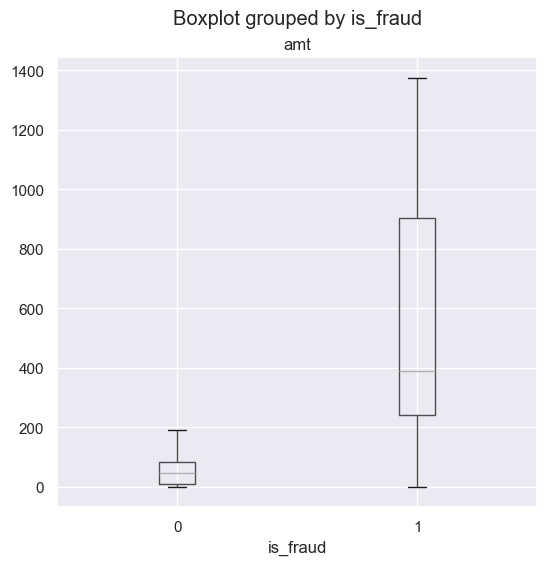

In [17]:
df.boxplot(column = 'amt', by = 'is_fraud', figsize = (6, 6), showfliers=False)

Separating the transaction and merchant data for K-Means clustering.

In [18]:
customer = df.loc[:,['trans_num','lat','long']]
merchant = df.loc[:,['merchant', 'merch_lat', 'merch_long']]
lat_long = df.loc[:,['lat', 'long']]
merch_lat_long = df.loc[:,['merch_lat', 'merch_long']]

The below cell performs K-Means clustering on the customer and merchant location coordinates on a range of 2 to 15 clusters. 2 elbow curves are plotted to determine the optimal amount of clusters to divide the locations into.

C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init

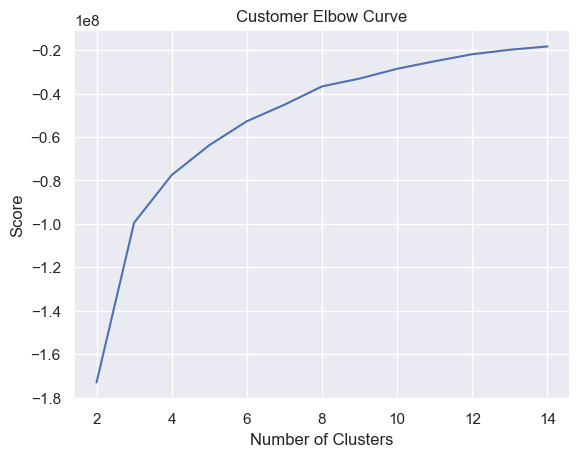

C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init

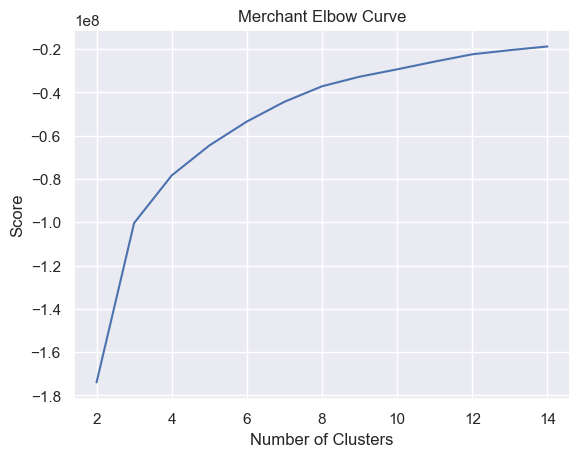

In [19]:
K_clusters = range(2,15)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(lat_long).score(lat_long) for i in range(len(kmeans))]# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Customer Elbow Curve')
plt.show()

score = [kmeans[i].fit(merch_lat_long).score(merch_lat_long) for i in range(len(kmeans))]# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Merchant Elbow Curve')
plt.show()

Assigning the location coordinates to 1 of the 8 clusters. As seen above, the optimal amount of clusters seems to be 8 for both elbow curves - this makes sense as all transactions occurred in the US and both sets of data are generally similar. Using more clusters leads to diminishing returns and runs the risk of overfitting.

In [20]:
kmeans = KMeans(n_clusters = 8, init ='k-means++')
kmeans.fit(lat_long) # Compute k-means clustering.

customer['transaction_area'] = kmeans.fit_predict(lat_long)

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(lat_long) # Labels of each point

customer.head(10)

C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,trans_num,lat,long,transaction_area
0,0b242abb623afc578575680df30655b9,36.0788,-81.1781,3
1,1f76529f8574734946361c461b024d99,48.8878,-118.2105,2
2,a1a22d70485983eac12b5b88dad1cf95,42.1808,-112.2620,7
3,6b849c168bdad6f867558c3793159a81,46.2306,-112.1138,7
4,a41d7549acf90789359a9aa5346dcb46,38.4207,-79.4629,0
5,189a841a0a8ba03058526bcfe566aab5,40.3750,-75.2045,0
6,83ec1cc84142af6e2acf10c44949e720,37.9931,-100.9893,7
7,6d294ed2cc447d2c71c7171a3d54967c,38.8432,-78.6003,0
8,fc28024ce480f8ef21a32d64c93a29f5,40.3359,-79.6607,0
9,3b9014ea8fb80bd65de0b1463b00b00e,36.5220,-87.3490,4


In [21]:
kmeans = KMeans(n_clusters = 8, init ='k-means++')
kmeans.fit(merch_lat_long) # Compute k-means clustering.

merchant['merchant_area'] = kmeans.fit_predict(merch_lat_long)

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(merch_lat_long) # Labels of each point

merchant.head(10)

C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\envs\capstone\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,merchant,merch_lat,merch_long,merchant_area
0,"Rippin, Kub and Mann",36.011293,-82.048315,4
1,"Heller, Gutmann and Zieme",49.159047,-118.186462,2
2,Lind-Buckridge,43.150704,-112.154481,6
3,"Kutch, Hermiston and Farrell",47.034331,-112.561071,6
4,Keeling-Crist,38.674999,-78.632459,5
5,"Stroman, Hudson and Erdman",40.653382,-76.152667,5
6,Rowe-Vandervort,37.162705,-100.153370,0
7,Corwin-Collins,38.948089,-78.540296,5
8,Herzog Ltd,40.351813,-79.958146,5
9,"Schoen, Kuphal and Nitzsche",37.179198,-87.485381,1


Using a scatter plot to visualize the clusters.

<Axes: xlabel='long', ylabel='lat'>

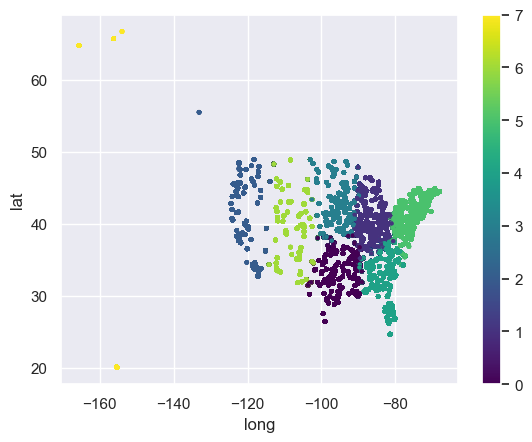

In [22]:
customer.plot.scatter(x = 'long', y = 'lat', c=labels, s=5, cmap='viridis')

#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20, alpha=0.5)

<Axes: xlabel='merch_long', ylabel='merch_lat'>

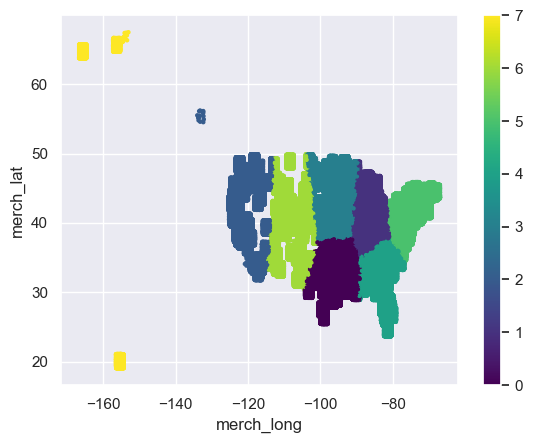

In [23]:
merchant.plot.scatter(x = 'merch_long', y = 'merch_lat', c=labels, s=5, cmap='viridis')

#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20, alpha=0.5)

The latitude and longitude columns are removed from the data frame as the cluster label now represents the particular area where the transaction took place. The transaction number and merchant name are also dropped as they are no longer needed.

In [24]:
customer = customer[['trans_num', 'transaction_area']]
merchant = merchant[['merchant', 'merchant_area']]

df['transaction_area'] = customer['transaction_area']
df['merchant_area'] = merchant['merchant_area']
df.drop(['lat', 'long', 'merch_lat', 'merch_long', 'merchant', 'trans_num'], axis=1, inplace=True)
df.head(5)

,category,amt,is_fraud,transaction_area,merchant_area
0,8,4.97,0,3,4
1,4,107.23,0,2,2
2,0,220.11,0,7,6
3,2,45.00,0,7,6
4,9,41.96,0,0,5


Exporting the cleaned CSV to a new file. The cleaned dataset is now ready to be analyzed using SMOTE and XGBoost.

In [25]:
df.to_csv('~/Desktop/cleanedFraudData.csv', index=False)